# [E-15] 문자를 읽을 수 있는 딥러닝
**문자를 읽는 기술인 OCR(Optical Character Recognition, 광학 문자 인식)**은 산업적으로 매우 유용한 기술이다. <br>
사람이 문자를 읽으려면,
1. 문자가 있다는 것을 **인식**
2. 인식한 문자를 **해독**
<br>

과정을 거치고, 기계가 문자를 읽은 과정도 이와 다르지 않다.
1. 문자의 존재를 **Detection**
2. 어떤 문자인지 판독하는 **Recognition**
<br>

그런데 정말 기계가 사진 속 글자를 잘 읽을 수 있을지 확신할 수 없다. 그래서 구글의 클라우드 기반 OCR API를 통해 손쉽게 딥러닝 기반의 최신 OCR을 테스트해 볼 수 있다. 이 API를 이용해 애플리케이션을 만들 수 있다. 단, 비용 결제가 필요함.

문자 모델은 보통 두 단계로 이뤄진다.
1. 입력 받은 사진 속에서 문자의 위치를 찾아내는 Text Detection(문자 검출)
2. 찾은 문자 영역으로부터 문자를 읽어내는 것은 Text Recognotion(문자 인식)

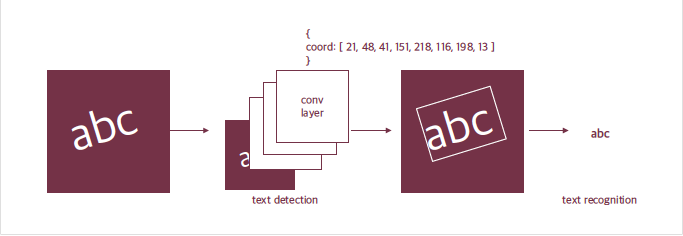

위 그림에서는 문자의 영역을 표현하는 방법으로 사각형의 네 꼭짓점 좌표를 알려 주는 방법을 제시하고 있다. 하지만 다른 도형이나 표현 방법을 사용할 수도 있을 것이다.

## 사진 속 문자 찾아내기-detection
사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 Object Detection(객체 인식) 방법으로 접근한다. 딥러닝 기반 객체 검출 방법에는,
* Regression(회귀)
    * 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습한다.
* Segmentation
    * 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제(pixel-wise classification)라고 볼 수 있다.
    <br>
    <br>
    
문자를 찾아내는 딥러닝 모델이 우리가 흔히 들어본 object detection과 큰 차이가 없다.

## 사진 속 문자 읽어내기-recognition
문자 인식은 사진 속에서 문자를 검출해 내는 검출 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정이다.<br> 문자 인식 모델은 작게 잘린 이미지가 들어오면 이미지 속에 어떤 단어가 포함됐는지 찾아낸다.<br>
<br>
사실 이 과정은 이미지 문제보다 자연어 처리에서 많은 영감을 받았다. 이미지 내의 문자 인식 모델의 기본적인 방법 중 하나가 바로 CNN과 RNN을 결합한 CRNN 모델이다. 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것이다.

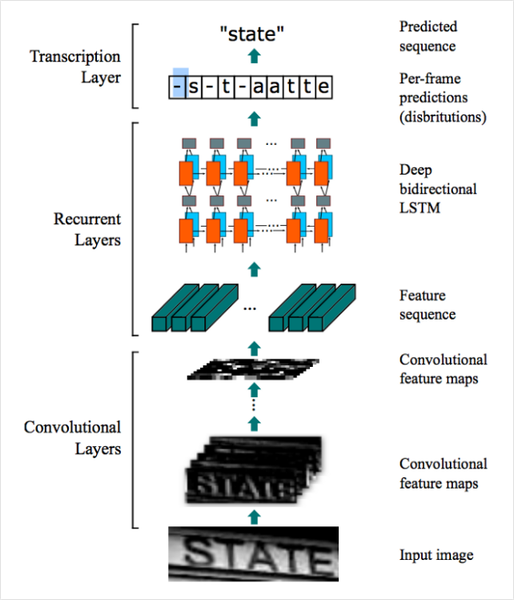

## keras-ocr 써보기
keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해준다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용한다.

In [1]:
# 인식 결과의 시각화를 위한 matplotlib.pyplot를 불러온다
# keras_ocr.pipeline.Pipeline()은 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치를 불러온다.
# 검출기와 인식기를 위한 가중치 하나씩 불러온다.
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [2]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

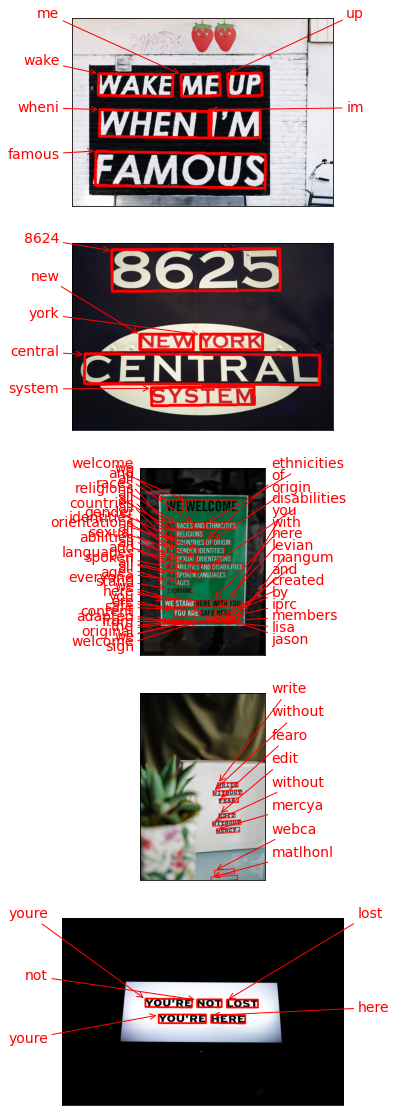

In [3]:
# 시각화
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

단, keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델이다. 한글 텍스트의 detection은 정상적으로 진행되더라도, recognition 결과가 엉뚱하게 나올 수 있음.

## 테서랙트 써보기

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png


In [6]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

El,

—

Done


***

## 프로젝트: 다양한 OCR 모델 비교하기
* 루브릭
    * 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
    * 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
    * 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import pytesseract
from PIL import Image
from pytesseract import Output

from glob import glob

### step1. 검증용 데이터셋 준비
처방전에 나오는 문자를 얼마나 잘 인식하는지 테스트하기 위한 이미지 14장을 준비하였다.

In [2]:
image_path = os.getenv('HOME') + '/aiffel/ocr_python/test2/'
img_list = glob(image_path + '*.jpg')
img_list.sort()
img_list

['/aiffel/aiffel/ocr_python/test2/test1.jpg',
 '/aiffel/aiffel/ocr_python/test2/test10.jpg',
 '/aiffel/aiffel/ocr_python/test2/test11.jpg',
 '/aiffel/aiffel/ocr_python/test2/test12.jpg',
 '/aiffel/aiffel/ocr_python/test2/test13.jpg',
 '/aiffel/aiffel/ocr_python/test2/test14.jpg',
 '/aiffel/aiffel/ocr_python/test2/test2.jpg',
 '/aiffel/aiffel/ocr_python/test2/test3.jpg',
 '/aiffel/aiffel/ocr_python/test2/test4.jpg',
 '/aiffel/aiffel/ocr_python/test2/test5.jpg',
 '/aiffel/aiffel/ocr_python/test2/test6.jpg',
 '/aiffel/aiffel/ocr_python/test2/test7.jpg',
 '/aiffel/aiffel/ocr_python/test2/test8.jpg',
 '/aiffel/aiffel/ocr_python/test2/test9.jpg']

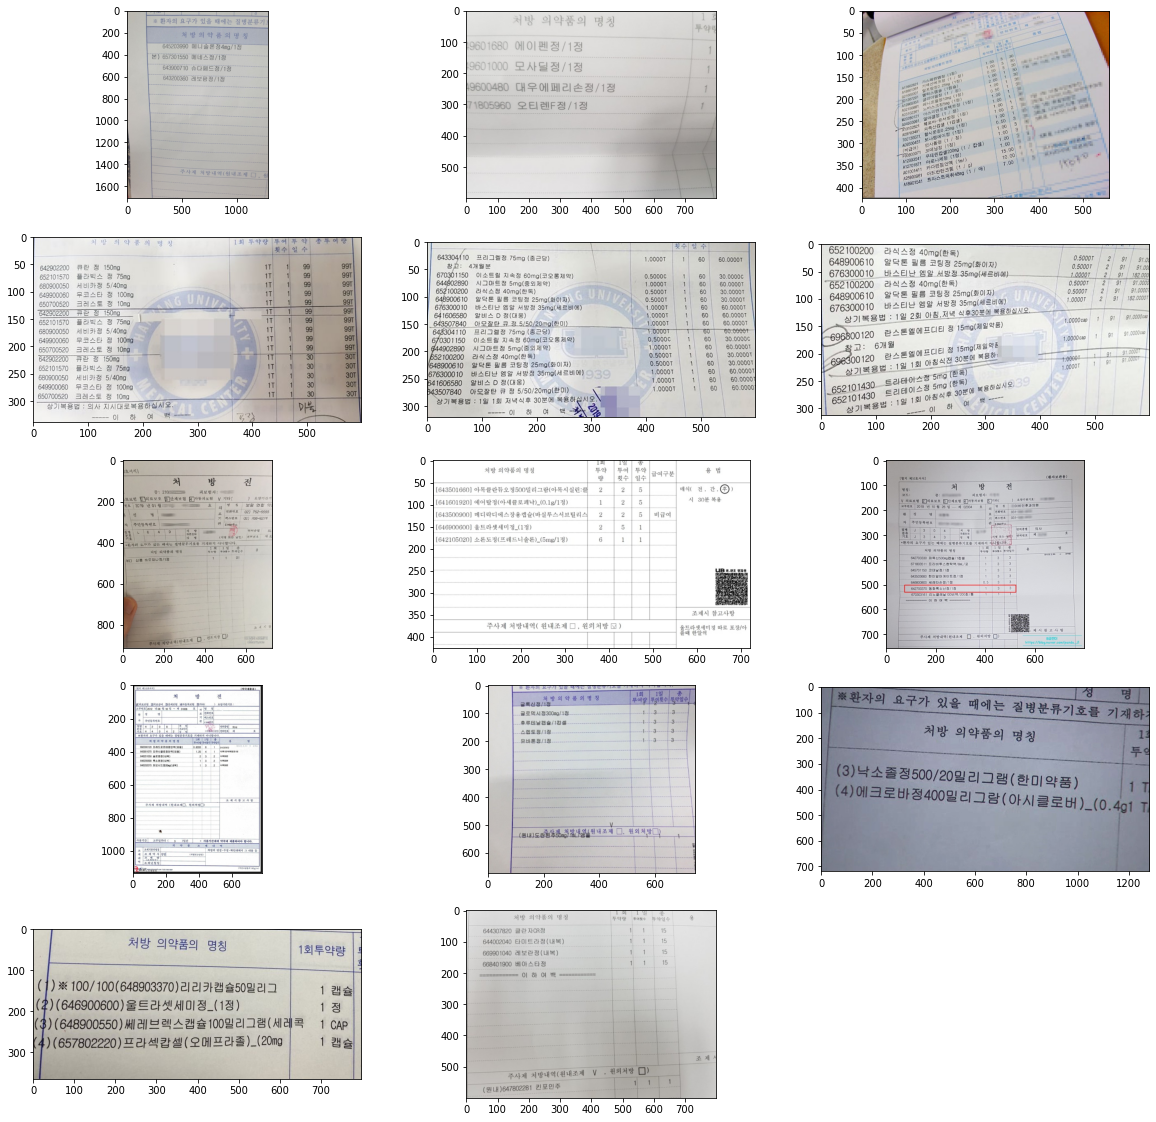

In [3]:
# 이미지 출력
plt.figure(figsize=(20, 20))
for i, im in enumerate(img_list):
    plt.subplot(5, 3, i+1)
    image = img.imread(im)
    plt.imshow(image)

### step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

#### keras-ocr

In [4]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images_keras_ocr = [keras_ocr.tools.read(image) for image in img_list]
prediction_groups = [pipeline.recognize([image]) for image in img_list]

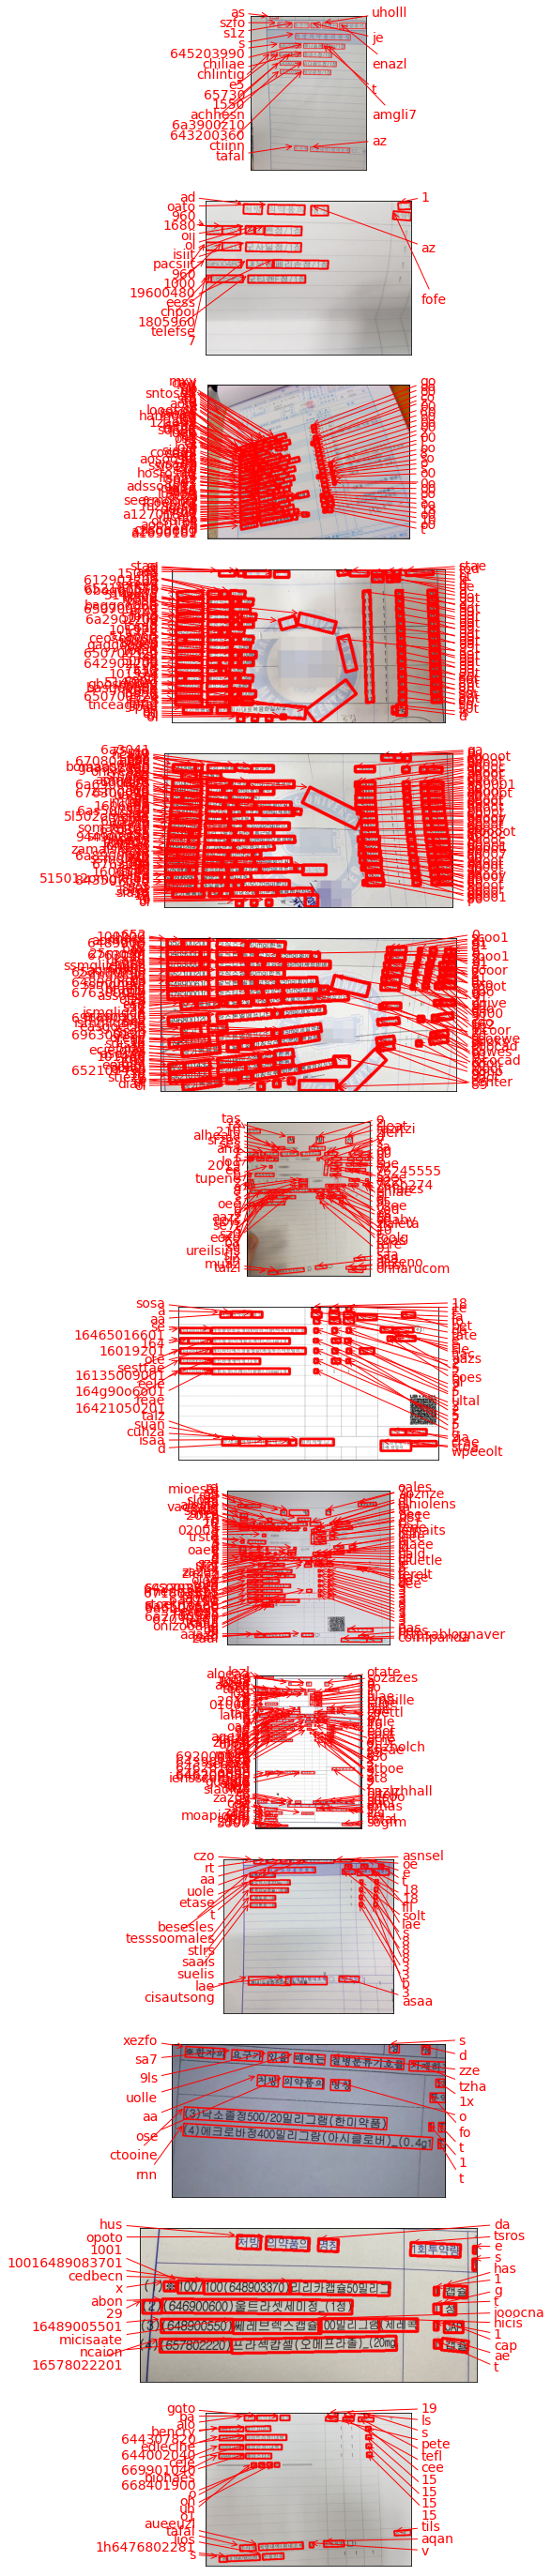

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

keras ocr은 한글 인식을 하지못한다. tesseract로 재시도

#### tesseract

In [7]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [8]:
img_list

['/aiffel/aiffel/ocr_python/test2/test1.jpg',
 '/aiffel/aiffel/ocr_python/test2/test10.jpg',
 '/aiffel/aiffel/ocr_python/test2/test11.jpg',
 '/aiffel/aiffel/ocr_python/test2/test12.jpg',
 '/aiffel/aiffel/ocr_python/test2/test13.jpg',
 '/aiffel/aiffel/ocr_python/test2/test14.jpg',
 '/aiffel/aiffel/ocr_python/test2/test2.jpg',
 '/aiffel/aiffel/ocr_python/test2/test3.jpg',
 '/aiffel/aiffel/ocr_python/test2/test4.jpg',
 '/aiffel/aiffel/ocr_python/test2/test5.jpg',
 '/aiffel/aiffel/ocr_python/test2/test6.jpg',
 '/aiffel/aiffel/ocr_python/test2/test7.jpg',
 '/aiffel/aiffel/ocr_python/test2/test8.jpg',
 '/aiffel/aiffel/ocr_python/test2/test9.jpg']

In [9]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test2/output'

cropped_image_path_list = {}
for i, img in enumerate(img_list):
    dir_path = work_dir + f'/{i}'
    path_list = crop_word_regions(img, dir_path)
    cropped_image_path_list[i] = path_list

/aiffel/aiffel/ocr_python/test2/output/0/0000.png
/aiffel/aiffel/ocr_python/test2/output/0/0001.png
/aiffel/aiffel/ocr_python/test2/output/0/0002.png
/aiffel/aiffel/ocr_python/test2/output/0/0003.png
/aiffel/aiffel/ocr_python/test2/output/0/0004.png
/aiffel/aiffel/ocr_python/test2/output/0/0005.png
/aiffel/aiffel/ocr_python/test2/output/0/0006.png
/aiffel/aiffel/ocr_python/test2/output/0/0007.png
/aiffel/aiffel/ocr_python/test2/output/0/0008.png
/aiffel/aiffel/ocr_python/test2/output/0/0009.png
/aiffel/aiffel/ocr_python/test2/output/0/0010.png
/aiffel/aiffel/ocr_python/test2/output/0/0011.png
/aiffel/aiffel/ocr_python/test2/output/0/0012.png
/aiffel/aiffel/ocr_python/test2/output/0/0013.png
/aiffel/aiffel/ocr_python/test2/output/0/0014.png
/aiffel/aiffel/ocr_python/test2/output/0/0015.png
/aiffel/aiffel/ocr_python/test2/output/0/0016.png
/aiffel/aiffel/ocr_python/test2/output/0/0017.png
/aiffel/aiffel/ocr_python/test2/output/0/0018.png
/aiffel/aiffel/ocr_python/test2/output/0/0019.png


In [10]:
cropped_image_path_list

{0: ['/aiffel/aiffel/ocr_python/test2/output/0/0000.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0001.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0002.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0003.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0004.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0005.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0006.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0007.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0008.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0009.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0010.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0011.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0012.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0013.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0014.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0015.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0016.png',
  '/aiffel/aiffel/ocr_python/test2/output/0/0017.png',
  '/aif

In [12]:
def recognize_images(i, cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    print(f'>>>>>>>>>>>>>>>>>>>>>>>>>>>>{i}>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print()

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for key, value in cropped_image_path_list.items():
    if value:
        recognize_images(key, value)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>0>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
~ "1 ()  와ㅅ [으 키 유ㄱ 〉 「 있을 때에는 질봉 느 = 나  【 | 방 | 의 약 3 | 품. 의 ㅁ 1 명 징 664652()3940() 내 는 6 성 4 4100 / 1 성 ~ ~ ~ 643200360 레보팡정/ 레5 | 보프 '팡정 / 7] 머 저때 | 거저 저지 제이 세이 | 스오 의 ~ 게재 | 것이제제이 처제 천지 스스 -  

>>>>>>>>>>>>>>>>>>>>>>>>>>>>1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
서브 나 의 야 끌 . 0 1 경칭 4  {내 1 | 게() | 변 슨 번. / 1 석 1내>() 1) )() 고 ^ |늘 승 벅 1 / 1 서 1냐50). 048() (어드 (0) |내 2 |슨 성 섭 , /1 서 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
도 뜨 =. -”ㄱ^. 끌어 은 0 000 | 00] 8 10 6 6 6 1 으 0 0 0 0 0 0000, 6 "1 을 ㅣ 다이 | 씨아 쁜은은싼디쌀든쁜.깐이 을일 을 압압끌은입이여일. .이을 을 이 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
6429022000 12 10 157 녀 634009(000005() 23 100 157 | 00055 내 0 0 > | 1) / (00502) 「642네121 ) | 557 1(00 157] (120 19] 54니네1) 0 1 ) 1) /()[152) 즐다믹스 ~ (200 써| 더 17 ,성 「 57 4000 고 - ^ 타 스티 10000 = 어 ^ ~ 든 ^ 14000 - 20 11 001 ㅣ 즐다믹스 스 /500 … 세번 =, 서  5, 4000 ” 5 6 ~ ~ 14000 (| ~ 두 1000 다 2 2 { 0 오 ^ 는 성 (500 서버 \댓 |성 ;

tesseract의 결과도 몇몇 단어를 제외하고는 뭘 의미하는지 모르겠다... 원인을 생각했을 때 처방전에 있는 문자 크기가 너무 작고 간격이 가까워서 잘 인식하지 못한 것이 아닌가 생각된다. 비교를 위해 영어 이미지로 다시 시도해봐야 할 것 같다.

### 영화 영문 포스터로 시도해보기

In [2]:
image_path = os.getenv('HOME') + '/aiffel/ocr_python/movie/'
img_list = glob(image_path + '*.jpeg')
img_list.sort()
img_list

['/aiffel/aiffel/ocr_python/movie/movie1.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie10.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie3.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie4.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie5.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie6.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie7.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie8.jpeg',
 '/aiffel/aiffel/ocr_python/movie/movie9.jpeg']

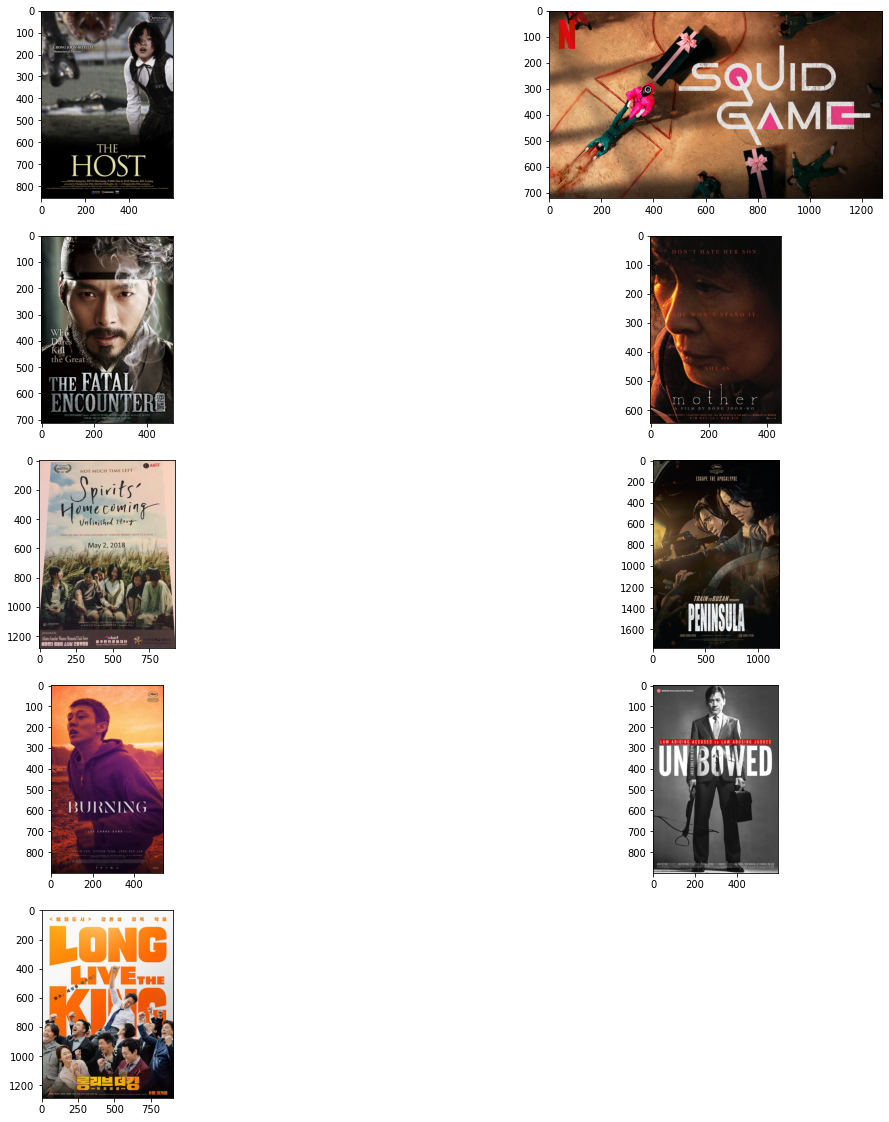

In [3]:
# 이미지 출력
plt.figure(figsize=(20, 20))
for i, im in enumerate(img_list):
    plt.subplot(5, 2, i+1)
    image = img.imread(im)
    plt.imshow(image)

#### keras-ocr

In [4]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images_keras_ocr = [keras_ocr.tools.read(image) for image in img_list]
prediction_groups = [pipeline.recognize([image]) for image in img_list]

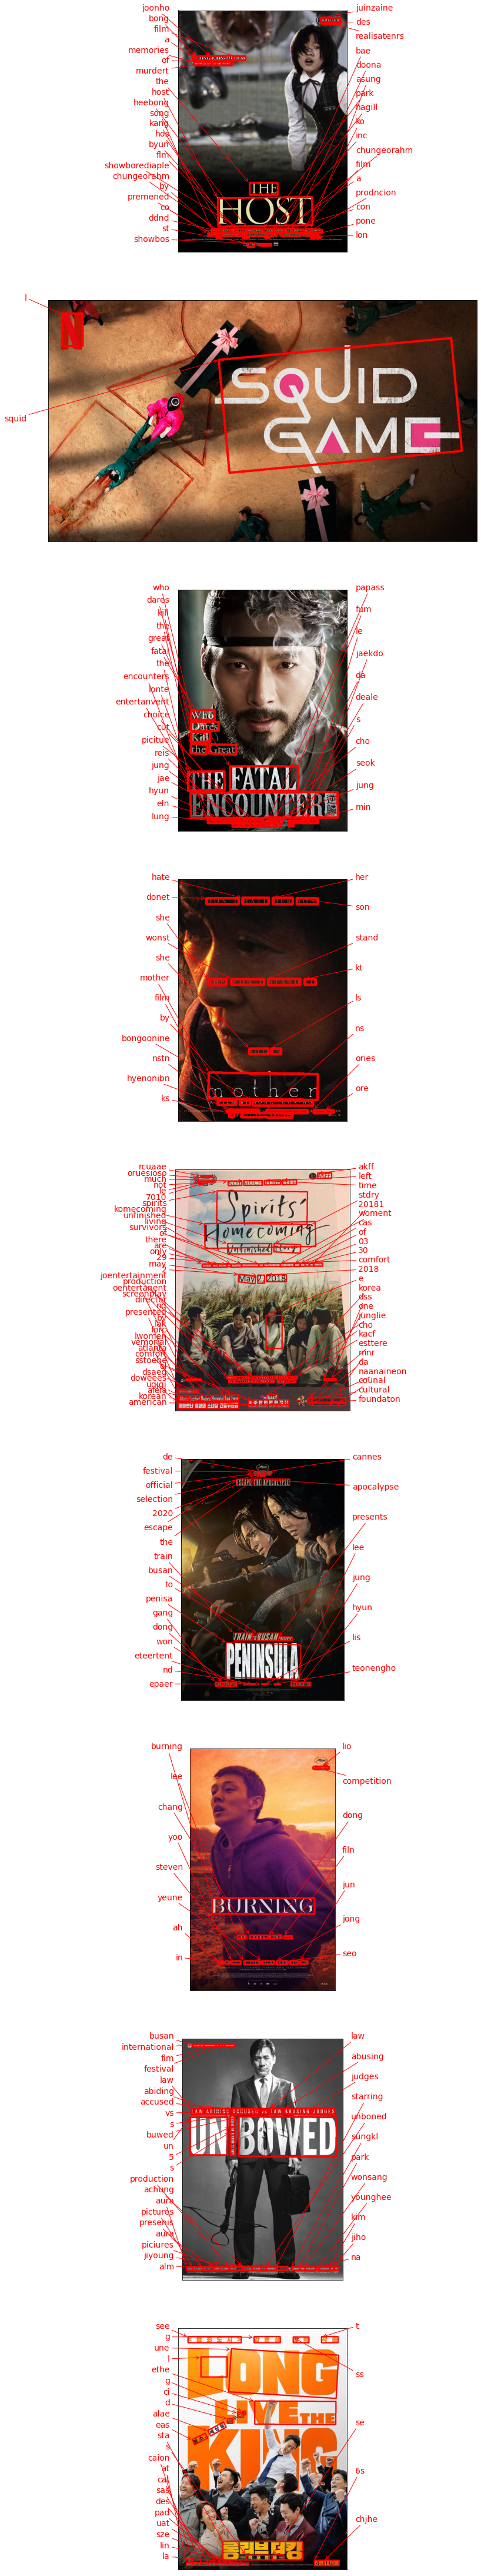

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(80, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

keras-ocr의 경우 가시적으로 봤을 때 영어는 잘 인식하는 것 같다. 하지만 squid game에서 'game'을 인식하지 못했는데, 알파벳 A와 E 부분이 명확하지 않다고 하더라도 나머지 G와 M 부분도 각각 인식하지 못한 것으로 보아 다른 이유가 있을 수도 있을 것 같다. 또한 '롱 리브 더 킹' 포스터는 실험적으로 넣어 봤는데 사람에 가리지 않은 'LONG' 부분에서도 인식을 잘 하지 못하는 것을 확인하였다. 

#### tesseract

In [7]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [8]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/movie/output'

cropped_image_path_list = {}
for i, img in enumerate(img_list):
    dir_path = work_dir + f'/{i}'
    path_list = crop_word_regions(img, dir_path)
    cropped_image_path_list[i] = path_list

/aiffel/aiffel/ocr_python/movie/output/0/0000.png
/aiffel/aiffel/ocr_python/movie/output/1/0000.png
/aiffel/aiffel/ocr_python/movie/output/2/0000.png
/aiffel/aiffel/ocr_python/movie/output/2/0001.png
/aiffel/aiffel/ocr_python/movie/output/2/0002.png
/aiffel/aiffel/ocr_python/movie/output/2/0003.png
/aiffel/aiffel/ocr_python/movie/output/2/0004.png
/aiffel/aiffel/ocr_python/movie/output/2/0005.png
/aiffel/aiffel/ocr_python/movie/output/3/0000.png
/aiffel/aiffel/ocr_python/movie/output/3/0001.png
/aiffel/aiffel/ocr_python/movie/output/3/0002.png
/aiffel/aiffel/ocr_python/movie/output/3/0003.png
/aiffel/aiffel/ocr_python/movie/output/3/0004.png
/aiffel/aiffel/ocr_python/movie/output/3/0005.png
/aiffel/aiffel/ocr_python/movie/output/3/0006.png
/aiffel/aiffel/ocr_python/movie/output/3/0007.png
/aiffel/aiffel/ocr_python/movie/output/3/0008.png
/aiffel/aiffel/ocr_python/movie/output/3/0009.png
/aiffel/aiffel/ocr_python/movie/output/3/0010.png
/aiffel/aiffel/ocr_python/movie/output/3/0011.png


In [9]:
cropped_image_path_list

{0: ['/aiffel/aiffel/ocr_python/movie/output/0/0000.png'],
 1: ['/aiffel/aiffel/ocr_python/movie/output/1/0000.png'],
 2: ['/aiffel/aiffel/ocr_python/movie/output/2/0000.png',
  '/aiffel/aiffel/ocr_python/movie/output/2/0001.png',
  '/aiffel/aiffel/ocr_python/movie/output/2/0002.png',
  '/aiffel/aiffel/ocr_python/movie/output/2/0003.png',
  '/aiffel/aiffel/ocr_python/movie/output/2/0004.png',
  '/aiffel/aiffel/ocr_python/movie/output/2/0005.png'],
 3: ['/aiffel/aiffel/ocr_python/movie/output/3/0000.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0001.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0002.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0003.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0004.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0005.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0006.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0007.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0008.png',
  '/aiffel/aiffel/ocr_python/movie/output/3/0009.p

In [10]:
def recognize_images(i, cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    print(f'>>>>>>>>>>>>>>>>>>>>>>>>>>>>{i}>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print()

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for key, value in cropped_image_path_list.items():
    if value:
        recognize_images(key, value)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>0>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
5 =3 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  yl  * K, fn UP: 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
aN gy ee: ee Ree pie i Oy ie i ] *~ Dae me -" ore ae 1 FILM eee men ae TOON-HO a a's ioe | Wm \ oc a | oe WON BIN   

>>>>>>>>>>>>>>>>>>>>>>>>>>>>4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
(2 AKFEF Qiesy NOT MUCH TIME I FFL pivit gmecoumi" Untinished Stirg— f THERE ARF (ONLY AG LIVING, SURVIVORS ( }} “COMFORT WOMEN LAS [ F 3.30.70 15 c May Z 2018  eZ AS a (SOR eR! tA Be i | JOENTI : (eRe an KOREA Too ean eee and Bee eae eer.  jungla ew presented by AYPTIP Winn VT TGA PR Nn: —kac  (a i Wa | eed  mE a4  atid Re Rai od bo! ea 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
| % [ r, EL TALAY: We LAI UE TNT HANG if | EE 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
- A : 2 oe ee Oe ee ee 6 Fu 

In [11]:
# 3번 시각화용 print문 제거
def recognize_images_result(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)

## 테스트 결과에 대해서
keras-ocr과 tesseract의 결과를 한 눈에 비교하는 코드 참고: https://github.com/nameunji/aiffel_project/blob/main/ocr_python/ocr.ipynb

In [12]:
import time

plt.figure(figsize=(50, 50))
for i, im in enumerate(img_list):
    print(f'{i}번째 이미지 결과 >>>>>>>>')
    print('<keras-ocr>')
    keras_ocr_result = [txt[0] for txt in prediction_groups[i][0]]
    keras_ocr_result = ' '.join(keras_ocr_result)
    print(keras_ocr_result)
    print('<Tesseract>')
    if cropped_image_path_list[i]:
        recognize_images_result(cropped_image_path_list[i])
    print()

0번째 이미지 결과 >>>>>>>>
<keras-ocr>
juinzaine des realisatenrs bong joonho film a memories of murdert the host song bae kang hos byun heebong park hagill doona ko asung chungeorahm flm showborediaple inc chungeorahm film premened by a prodncion co con pone ddnd lon st showbos
<Tesseract>
 

1번째 이미지 결과 >>>>>>>>
<keras-ocr>
l squid
<Tesseract>
5 =3 

2번째 이미지 결과 >>>>>>>>
<keras-ocr>
who dares kill the great fatal the encounters lonte entertanvent choice cut picitue papass fum le jaekdo reis da deale s jung jae cho seok hyun eln lung jung min
<Tesseract>
  yl  * K, fn UP: 

3번째 이미지 결과 >>>>>>>>
<keras-ocr>
donet hate her son she wonst stand kt she ls mother film by bongoonine nstn ns ories ore hyenonibn ks
<Tesseract>
aN gy ee: ee Ree pie i Oy ie i ] *~ Dae me -" ore ae 1 FILM eee men ae TOON-HO a a's ioe | Wm \ oc a | oe WON BIN   

4번째 이미지 결과 >>>>>>>>
<keras-ocr>
akff rcuaae oruesioso left time much not le 7010 spirits komecoming unfinished stdry 20181 woment cas of 03 30 comfort living survi

<Figure size 3600x3600 with 0 Axes>

## 회고

1. 처방전 이미지로 ocr을 해본 결과 한글을 잘 인식하지 못한 것은 keras-ocr은 한글 모델로 적용하지 않아서인 것 같지만 한글을 어떻게 적용해야하는지 잘 모르겠다. 이후 영화 포스터의 결과로 미루어 짐작해보면 아마 한글을 적용했어도 좋은 결과를 기대하기는 힘들 것 같다. 한글을 적용한 tesseract에서도 몇개의 단어를 제외하고는 알아보기 힘들 정도의 결과가 나와 실망스러웠는데, 개선할 부분이 어떤 것이 있는지 알아보고 싶다.

2. 영화 포스터의 경우 일부러 영문으로 제작된 포스터만 수집해 시도했는데, 비교적 한글 이미지보다 인식을 잘 하는 것을 확인할 수 있었다. 하지만 단어의 크기가 제각각이거나 알파벳 안에 어떤 효과가 적용될 경우 잘 인식하지 못했다.

ocr을 활용해 처방전의 문자를 인식해 어떤 약을 복용하는지에 대한 정보를 알 수 있게 되면 약의 오용 또는 남용을 방지할 수 있을 것이라 기대된다.